In [19]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as pyplot
import seaborn as sns

## Loading data

In [2]:
df = pd.read_csv('corneal.csv')
df.head(5)

,SMILES,logPerm
0,CC1CC2C3CCC(C3(CC(C2(C4(C1=CC(=O)C=C4)C)F)O)C)...,5.135798
1,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O,5.347108
2,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)N,5.393628
3,C(C(CO)O)O,3.806662
4,CC12CCC(=O)C=C1CCC3C2C(CC4(C3CCC4(C(=O)CO)O)C)O,4.442651


### Converting to MACCS fp

In [3]:
smiles = df['SMILES'].to_list()

In [4]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df2 = pd.DataFrame(MACCS_list,columns=header)
df2.insert(loc=0, column='smiles', value=smiles)
df2.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,CC1CC2C3CCC(C3(CC(C2(C4(C1=CC(=O)C=C4)C)F)O)C)...,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,1,1,0
1,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)O,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
2,CC(C1=CC(=C(C=C1)C2=CC=CC=C2)F)C(=O)N,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


In [5]:
X = df2.iloc[:, 1:168].astype(int)

In [6]:
y = df['logPerm']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
X_train.shape

(96, 167)

In [53]:
model =  XGBRegressor(random_state=10)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [54]:
y_pred = model.predict(X_test)

In [55]:
r2 = r2_score(y_test, y_pred)
r2

0.7401609350384324

In [56]:
y_pred_train = model.predict(X_train)

In [57]:
r2_train = r2_score(y_train, y_pred_train)
r2_train

0.9899397450220019

Overfitiing is observed

### XGBRegressor hyperparameter optimization

In [87]:
def hyperParameterTuning(X_train, y_train): 
    param_tuning = { 
        'learning_rate': [0.01, 0.1, 0.2], 
        'max_depth': [2, 3, 5], 
        'min_child_weight': [5, 10], 
        'subsample': [0.5, 0.7, 1], 
        'colsample_bytree': [0.1, 0.3]
    } 

    xgb_model = XGBRegressor(random_state=10) 

    gsearch = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_tuning,
                           scoring='neg_mean_squared_error',  
                           cv=10, 
                           n_jobs=-1, 
                           verbose=1) 

    gsearch.fit(X_train, y_train) 

    return gsearch.best_params_

In [88]:
hyperParameterTuning(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


{'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_weight': 10,
 'subsample': 1}

### Train model with optimized hyperparameters

In [9]:
optimized_model = XGBRegressor(colsample_bytree = 0.3,
                                learning_rate = 0.1,
                                max_depth = 2,
                                min_child_weight = 5,
                                subsample = 1, 
                                random_state = 10)

In [10]:
optimized_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [11]:
optimized_model.score(X_test, y_test)

0.6816046606707047

In [12]:
optimized_model.score(X_train, y_train)

0.7744200264048101

### Save the model

In [20]:
optimized_model.save_model('corneal.json')

### Feature importance

In [34]:
importance = optimized_model.feature_importances_

In [35]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [37]:
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.030]

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_16140\2160253773.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')


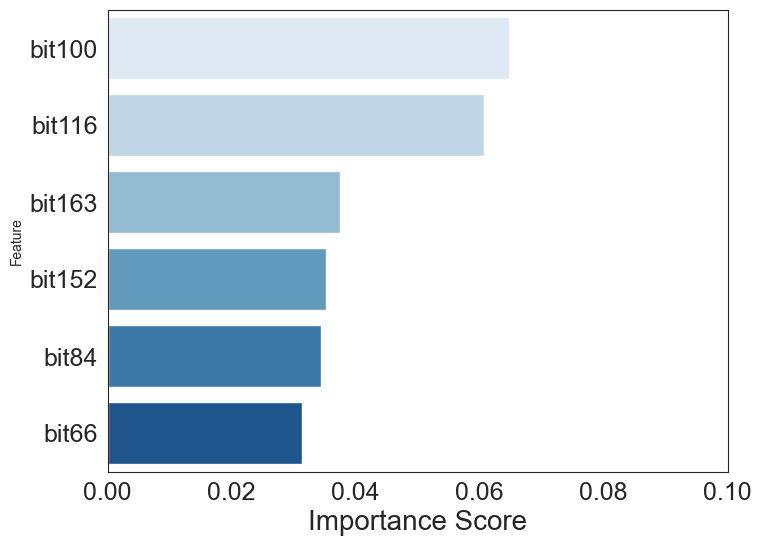

In [41]:
sns.set_style("white")

pyplot.figure(figsize=(8, 6))


sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')
sns.set_style("whitegrid")
pyplot.xlim(0, 0.1)
pyplot.xlabel('Importance Score', fontsize = 20)
pyplot.tick_params(axis='both', labelsize=18)

pyplot.savefig('FI_corneal.svg', dpi=700)
pyplot.show()

## Case study
Here we evaluate mean corneal permeability of valid molecules obtained by FREEDD++ or updraded FREED++ model

Converting SMILES to MACCS fingerprints and deleting high correlated features

In [20]:
smiles = pd.read_csv('smiles_noML_100.csv')['Smiles'].to_list()

In [21]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df3 = pd.DataFrame(MACCS_list,columns=header)
df3.insert(loc=0, column='smiles', value=smiles)
df3.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,O=C(O)Cc1c(O)cccc1S(=O)(=O)NCOC(=O)Oc1ccccc1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
1,CC(=O)c1c(N[SH](=O)=O)cc(CC(=O)O)cc1-c1c[nH]c2...,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,COCc1cc(-c2ccoc2)c(C)cc1C(C(=O)O)C1CC1,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0


In [22]:
X = np.array(df3.iloc[:, 1:168])

In [23]:
permeability = optimized_model.predict(X)

In [24]:
mean_permeability = np.mean(permeability)
mean_permeability

3.4199533

### Calculating average permeability for molecules generated by FREED++

In [20]:
noML = [3.4199533, 3.3393216, 3.7765508, 3.5080233, 3.1997707]
mean_noML = np.mean(noML)
mean_noML

3.44872394

In [91]:
std = np.std(noML)
std

0.19274916428553035

### Visualizing of model performance

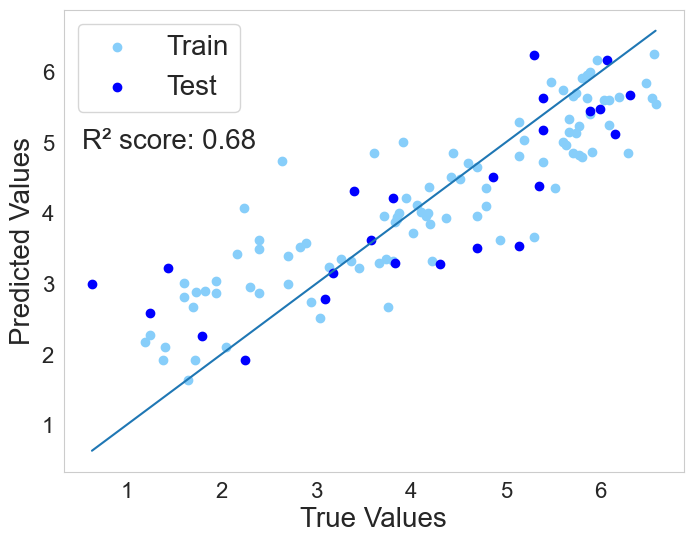

In [42]:
y_true_train = y_train
y_true_test = y_test

y_pred_train = optimized_model.predict(X_train)
y_pred_test = optimized_model.predict(X_test)


r2_test = r2_score(y_true_test, y_pred_test)


pyplot.figure(figsize=(8, 6))


pyplot.scatter(y_true_train, y_pred_train, color='#87CEFA', label='Train', alpha=1)


pyplot.scatter(y_true_test, y_pred_test, color='blue', label='Test', alpha=1)


pyplot.plot([min(min(y_true_train), min(y_true_test)), max(max(y_true_train), max(y_true_test))],
         [min(min(y_true_train), min(y_true_test)), max(max(y_true_train), max(y_true_test))],
)

pyplot.text(0.03, 0.7, f'R² score: {r2_test:.2f}', transform=plt.gca().transAxes, fontsize=20)


pyplot.xlabel('True Values', fontsize=20)
pyplot.ylabel('Predicted Values', fontsize=20)
pyplot.legend(fontsize=20)

pyplot.tick_params(axis='both', labelsize=16)
pyplot.grid()


pyplot.savefig('corneal_ML.svg', dpi=700, bbox_inches='tight')
pyplot.show()

